<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/weatherAus_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [2]:
fulldata = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/weatherAUS.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
fulldata['RainToday'].replace({'No':0, 'Yes':1}, inplace=True)
fulldata['RainTomorrow'].replace({'No':0, 'Yes':1}, inplace=True)

Text(0.5, 1.0, 'Distribution of RainTomorrow')

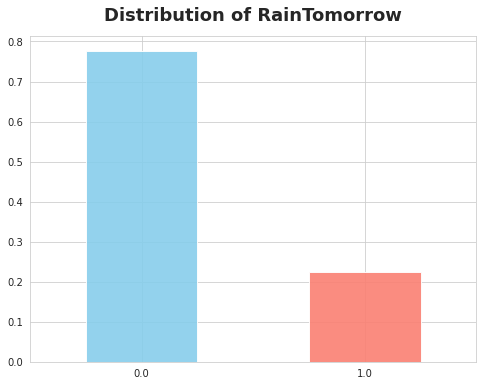

In [9]:
fig = plt.figure(figsize=(8,6))
fulldata.RainTomorrow.value_counts(normalize=True).plot.bar(color=['skyblue', 'salmon'], alpha=.9, rot=0)
plt.title('Distribution of RainTomorrow', fontsize=18, fontweight='bold', pad=15)

In [10]:
from sklearn.utils import resample
## RainTomorrow 오버샘플링 하려고한다.

In [12]:
no = fulldata[data.RainTomorrow == 0]
yes = fulldata[data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

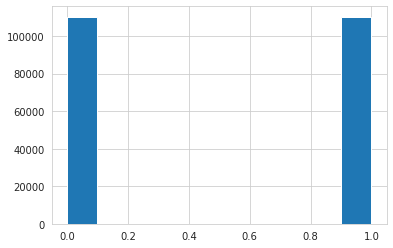

In [13]:
oversampled.RainTomorrow.hist()

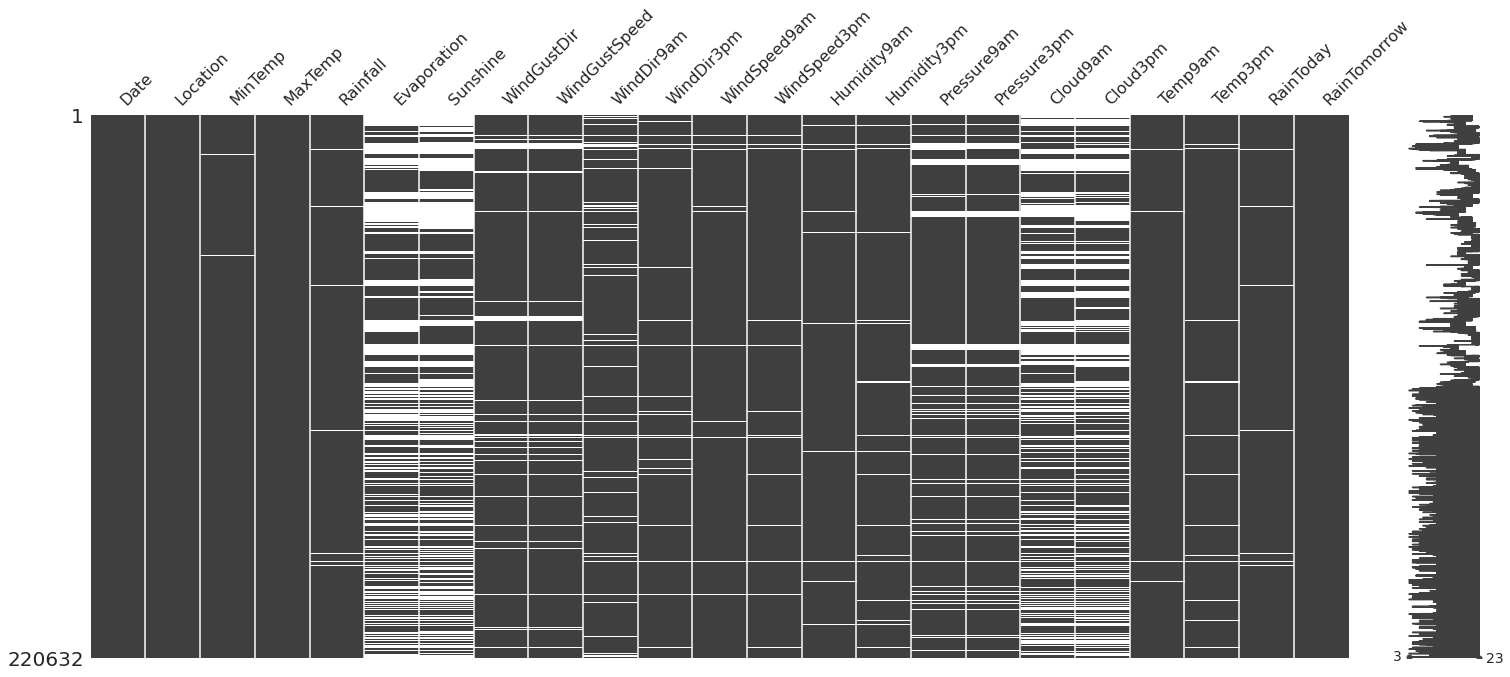

In [14]:
import missingno as msno
msno.matrix(oversampled)

In [15]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head()

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664
Pressure3pm,21746,0.098562


In [16]:
oversampled.select_dtypes(include=['object']).columns
## select_dtypes(include=[]) ==> 원하는 데이터타입 찾아주는것

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [17]:
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])
## object타입은 mode로 채움

In [18]:
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
  lencoders[col] = LabelEncoder()
  oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [20]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
## 결측치 제거 모듈

In [21]:
miceimputed = oversampled.copy(deep=True)
mice_imputer = IterativeImputer()
miceimputed.iloc[:,:] = mice_imputer.fit_transform(oversampled)
## 결측치 제거

In [22]:
miceimputed.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

In [23]:
## 이상값 처리 -IQR * 1.5 ~ IQR * 1.5 밖에 있으면 이상값
Q1 = miceimputed.quantile(0.25)  ## 25%
Q3 = miceimputed.quantile(0.75)  ## 75%
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.120044
Sunshine            5.979485
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.684676
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RainTomorrow        1.000000
dtype: float64


In [25]:
miceimputed = miceimputed[~((miceimputed < (Q1 - 1.5*IQR))|
(miceimputed > (Q3 + 1.5*IQR))).any(axis=1)]
miceimputed.shape
## 이상값 처리 완료

(170669, 23)

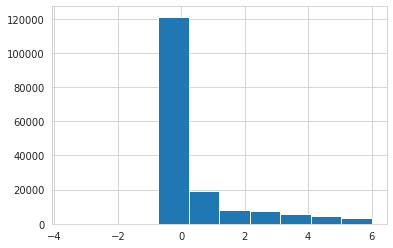

In [28]:
miceimputed.Rainfall.hist()

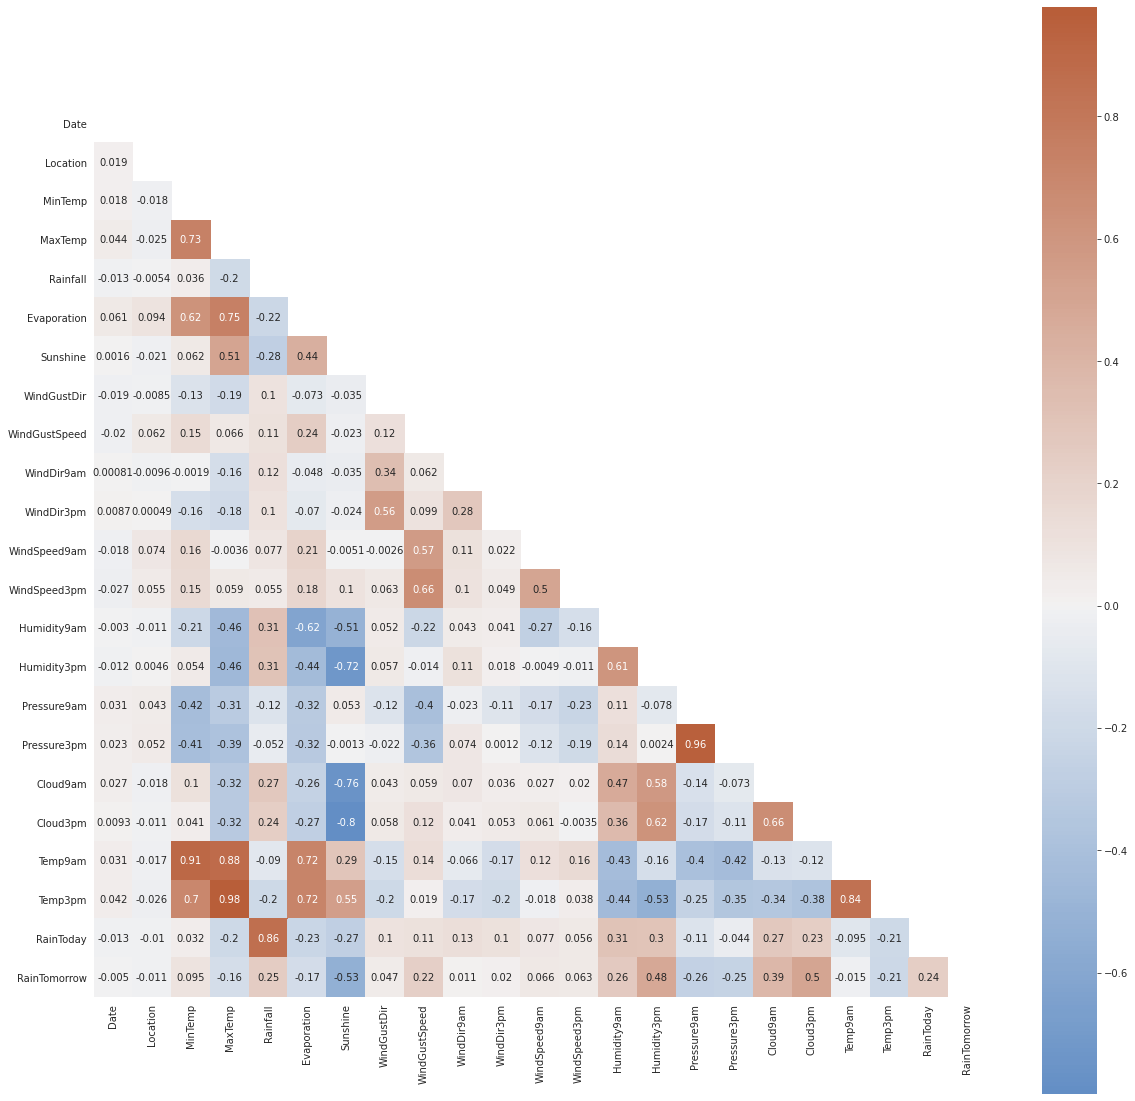

In [33]:
mask = np.triu(np.ones_like(miceimputed.corr(), dtype=np.bool))
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(miceimputed.corr(), annot=True, cmap=sns.diverging_palette(250, 25, as_cmap=True), vmax=None, center=0, square=True, mask=mask)

In [36]:
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(miceimputed)
data = pd.DataFrame(r_scaler.transform(miceimputed), columns=miceimputed.columns)
data.head()
## 스케일링 완료(minimaxscaling)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0.115284,0.041667,0.543417,0.514778,0.437385,0.569756,0.512042,0.866667,0.521127,0.866667,0.933333,0.551188,0.615385,0.551807,0.222773,0.245714,0.298295,0.868449,0.420458,0.506775,0.530612,0.24783,0.0
1,0.115575,0.041667,0.375350,0.568966,0.374872,0.563868,0.745836,0.933333,0.521127,0.400000,1.000000,0.173240,0.564103,0.247750,0.252666,0.328571,0.318182,0.339380,0.227713,0.514905,0.594388,0.24783,0.0
2,0.115866,0.041667,0.529412,0.583744,0.374872,0.695026,0.793365,1.000000,0.549296,0.866667,1.000000,0.527566,0.666667,0.180182,0.302488,0.242857,0.343750,0.347461,0.173437,0.617886,0.566327,0.24783,0.0
3,0.116157,0.041667,0.425770,0.640394,0.374872,0.584743,0.762539,0.266667,0.239437,0.600000,0.000000,0.338592,0.230769,0.259012,0.162986,0.528571,0.460227,0.297350,0.183513,0.539295,0.650510,0.24783,0.0
4,0.116448,0.041667,0.658263,0.746305,0.479060,0.638825,0.413485,0.866667,0.478873,0.066667,0.466667,0.244105,0.512821,0.675683,0.332382,0.334286,0.267045,0.784042,0.693747,0.531165,0.732143,0.24783,0.0


In [37]:
from sklearn.feature_selection import SelectKBest, chi2
X = data.loc[:, data.columns !='RainTomorrow']
Y = data['RainTomorrow']
selector = SelectKBest(chi2, k=10)
selector.fit(X,Y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'RainToday'],
      dtype='object')


In [39]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

X = miceimputed.drop('RainTomorrow', axis=1)
Y = miceimputed['RainTomorrow']
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=0))
selector.fit(X,Y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(RandomForestClassifier(n_estimators=100).fit(X,Y).feature_importances_)

['Sunshine', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
[0.03275395 0.02833954 0.03242857 0.03236553 0.02497738 0.03248613
 0.12873661 0.02081623 0.04110439 0.02180083 0.02161294 0.02162826
 0.02338384 0.0325682  0.11066192 0.04624377 0.06311484 0.06392741
 0.14225898 0.03170549 0.03434437 0.01274083]


In [45]:
x = miceimputed.drop(['RainTomorrow'], axis=1)
y = miceimputed['RainTomorrow']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.25, random_state=12345)

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
## 여기는 이제 와서 스케일링하네...(robust쓰면 되자나...)

In [78]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_auc_score, cohen_kappa_score
from sklearn.model_selection import GridSearchCV, cross_val_score

In [49]:
from sklearn.linear_model import LogisticRegression

param_lr = {'penalty':'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**param_lr)
model_lr.fit(x_train, y_train)
y_pred_lr = model_lr.predict(x_test)
print('Logistic Accuracy:', accuracy_score(y_test, y_pred_lr))

Logistic Accuracy: 0.794951720258742


In [50]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import xgboost as xgb

In [51]:
model_dectree = DecisionTreeClassifier(max_depth=100)
model_dectree.fit(x_train, y_train)
y_pred_dectree = model_dectree.predict(x_test)
print('DecisionTree Accuracy:', accuracy_score(y_test, y_pred_dectree))

DecisionTree Accuracy: 0.8770038436298866


In [53]:
model_rf = RandomForestClassifier(max_depth=100, n_jobs=-1)
model_rf.fit(x_train, y_train)
y_pred_rf = model_rf.predict(x_test)
print('RandomForest Accuracy:', accuracy_score(y_test, y_pred_rf))
print('RandomForest f1-score:', f1_score(y_test, y_pred_rf))
## 와... 결측치 그냥 iteractive imputer 하고 이상치만 제거했는데.. 이런값이

RandomForest Accuracy: 0.9559388769100966
RandomForest f1-score: 0.9510467659618791


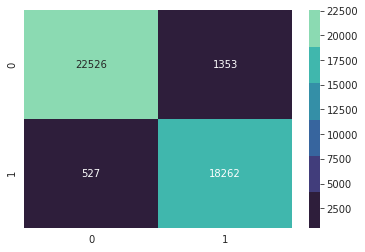

In [59]:
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap=sns.color_palette('mako'))

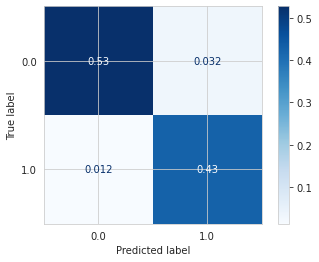

In [71]:
plot_confusion_matrix(model_rf, x_test, y_test, normalize='all', cmap=plt.cm.Blues)

In [58]:
model_xgb = xgb.XGBClassifier(max_depth=50)
model_xgb.fit(x_train, y_train)
y_pred_xgb = model_xgb.predict(x_test)
print('RandomForest Accuracy:', accuracy_score(y_test, y_pred_xgb))
print('RandomForest f1-score:', f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

RandomForest Accuracy: 0.9456501359332521
RandomForest f1-score: 0.939964273694566
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     23879
         1.0       0.92      0.97      0.94     18789

    accuracy                           0.95     42668
   macro avg       0.94      0.95      0.95     42668
weighted avg       0.95      0.95      0.95     42668



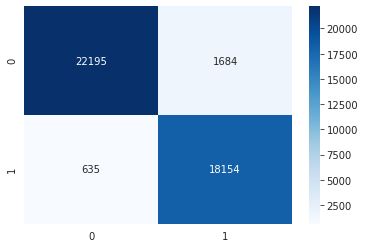

In [68]:
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), cmap=plt.cm.Blues, annot=True, fmt='d')

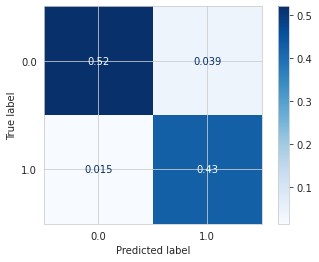

In [70]:
plot_confusion_matrix(model_xgb, x_test, y_test, normalize='all', cmap=plt.cm.Blues)

In [77]:
param_rf = {'n_estimators':np.arange(100,200,50)}
grid_rf = GridSearchCV(model_xgb, param_grid=param_rf, scoring='accuracy', cv=5 )
grid_rf.fit(x_train, y_train)
## GridSearch는 시간이 너무 걸리는 관계로 이번 커널은 안한다.

KeyboardInterrupt: ignored

In [92]:
def Model(Model):
  Model.fit(x_train, y_train)
  y_pred = Model.predict(x_test)
  print(f'accuracy 점수는', accuracy_score(y_test, y_pred))
  print(f'auc 값은', roc_auc_score(y_test, y_pred))
  print(f'Kappa 값은', cohen_kappa_score(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  plot_confusion_matrix(Model, x_test, y_test, normalize='all', cmap=plt.cm.Blues)

accuracy 점수는 0.9456501359332521
auc 값은 0.9478407068050886
Kappa 값은 0.8903833095582386
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     23879
         1.0       0.92      0.97      0.94     18789

    accuracy                           0.95     42668
   macro avg       0.94      0.95      0.95     42668
weighted avg       0.95      0.95      0.95     42668



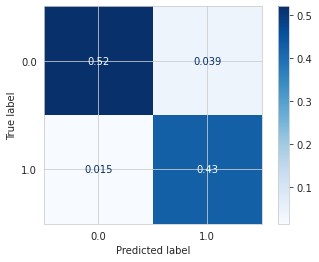

In [93]:
Model(xgb.XGBClassifier(max_depth=100, n_jobs=-1))

accuracy 점수는 0.9552592106496672
auc 값은 0.9570099146523112
Kappa 값은 0.9096596572393857
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96     23879
         1.0       0.93      0.97      0.95     18789

    accuracy                           0.96     42668
   macro avg       0.95      0.96      0.95     42668
weighted avg       0.96      0.96      0.96     42668



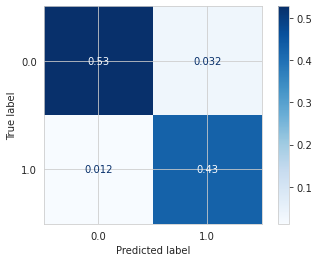

In [94]:
Model(RandomForestClassifier(max_depth=100, n_jobs=-1))

accuracy 점수는 0.8774960157495079
auc 값은 0.8780560382921746
Kappa 값은 0.7526071455314042
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89     23879
         1.0       0.85      0.88      0.86     18789

    accuracy                           0.88     42668
   macro avg       0.88      0.88      0.88     42668
weighted avg       0.88      0.88      0.88     42668



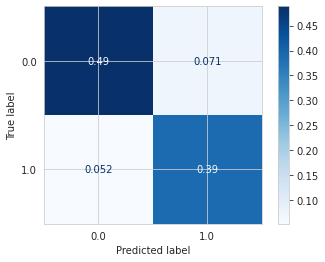

In [96]:
Model(DecisionTreeClassifier(max_depth=100))

Text(0.5, 1.0, 'Feature Importaces of RandomForest')

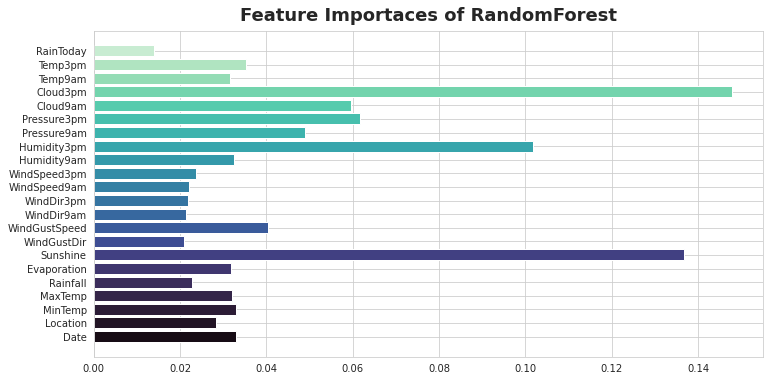

In [109]:
plt.subplots(figsize=(12,6))
plt.barh(x.columns, model_rf.feature_importances_, color=sns.color_palette('mako', n_colors=len(x.columns)))
plt.title('Feature Importaces of RandomForest', fontsize=18, fontweight='bold', pad=10)

Text(0.5, 1.0, 'Feature Importaces of XGBoost')

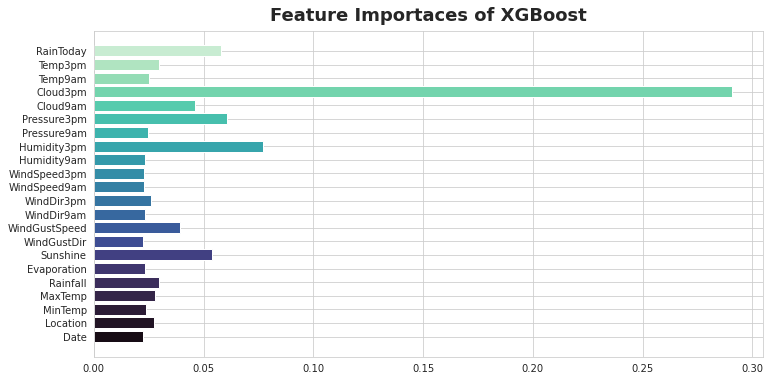

In [110]:
plt.subplots(figsize=(12,6))
plt.barh(x.columns, model_xgb.feature_importances_, color=sns.color_palette('mako', n_colors=len(x.columns)))
plt.title('Feature Importaces of XGBoost', fontsize=18, fontweight='bold', pad=10)

Text(0.5, 1.0, 'Feature Importaces of DecisionTree')

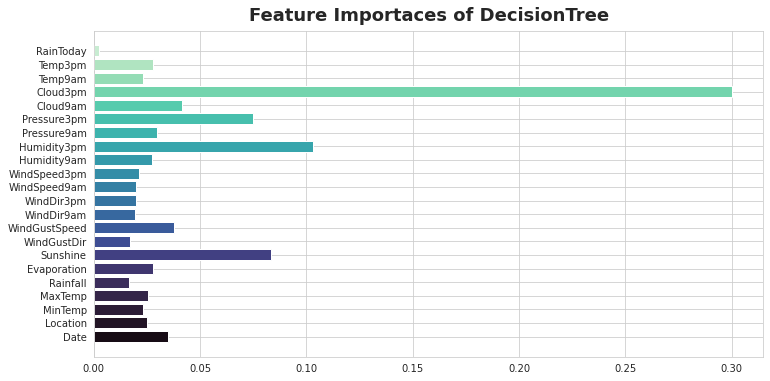

In [111]:
plt.subplots(figsize=(12,6))
plt.barh(x.columns, model_dectree.feature_importances_, color=sns.color_palette('mako', n_colors=len(x.columns)))
plt.title('Feature Importaces of DecisionTree', fontsize=18, fontweight='bold', pad=10)